### LANDMARK DATA GENERATOR

In [ ]:
%pip install mediapipe opencv-python

#### mediapipe


In [1]:
import mediapipe as mp
import cv2
import numpy as np
import os
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
from IPython.display import Image, display

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import tensorflow as tf

In [3]:
# draw_landmarks_on_image
MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

In [66]:
# STEP 2: Create an HandLandmarker object.
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

# STEP 3: Load the input image.
def detect(image_path="", image_data: np.array = None, view=True):
    if image_path:
        image = mp.Image.create_from_file(image_path)
    elif image_data is not None:
        image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image_data)
    else:
        raise ValueError("image_path or image_data must be provided")
    
    detection_result = detector.detect(image)
    
    if view:
        annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
        _, jpg  = cv2.imencode(".jpg", cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
        display(Image(jpg))
    return detection_result

In [59]:
def landmark2df(landmarks: list) -> pd.DataFrame:
    lns = dict(x=[], y=[], z=[])
    for landmark in landmarks:
        lns['x'].append(landmark.x)
        lns['y'].append(landmark.y)
        lns['z'].append(landmark.z)
    df = pd.DataFrame(lns, dtype=np.float32)
    return df

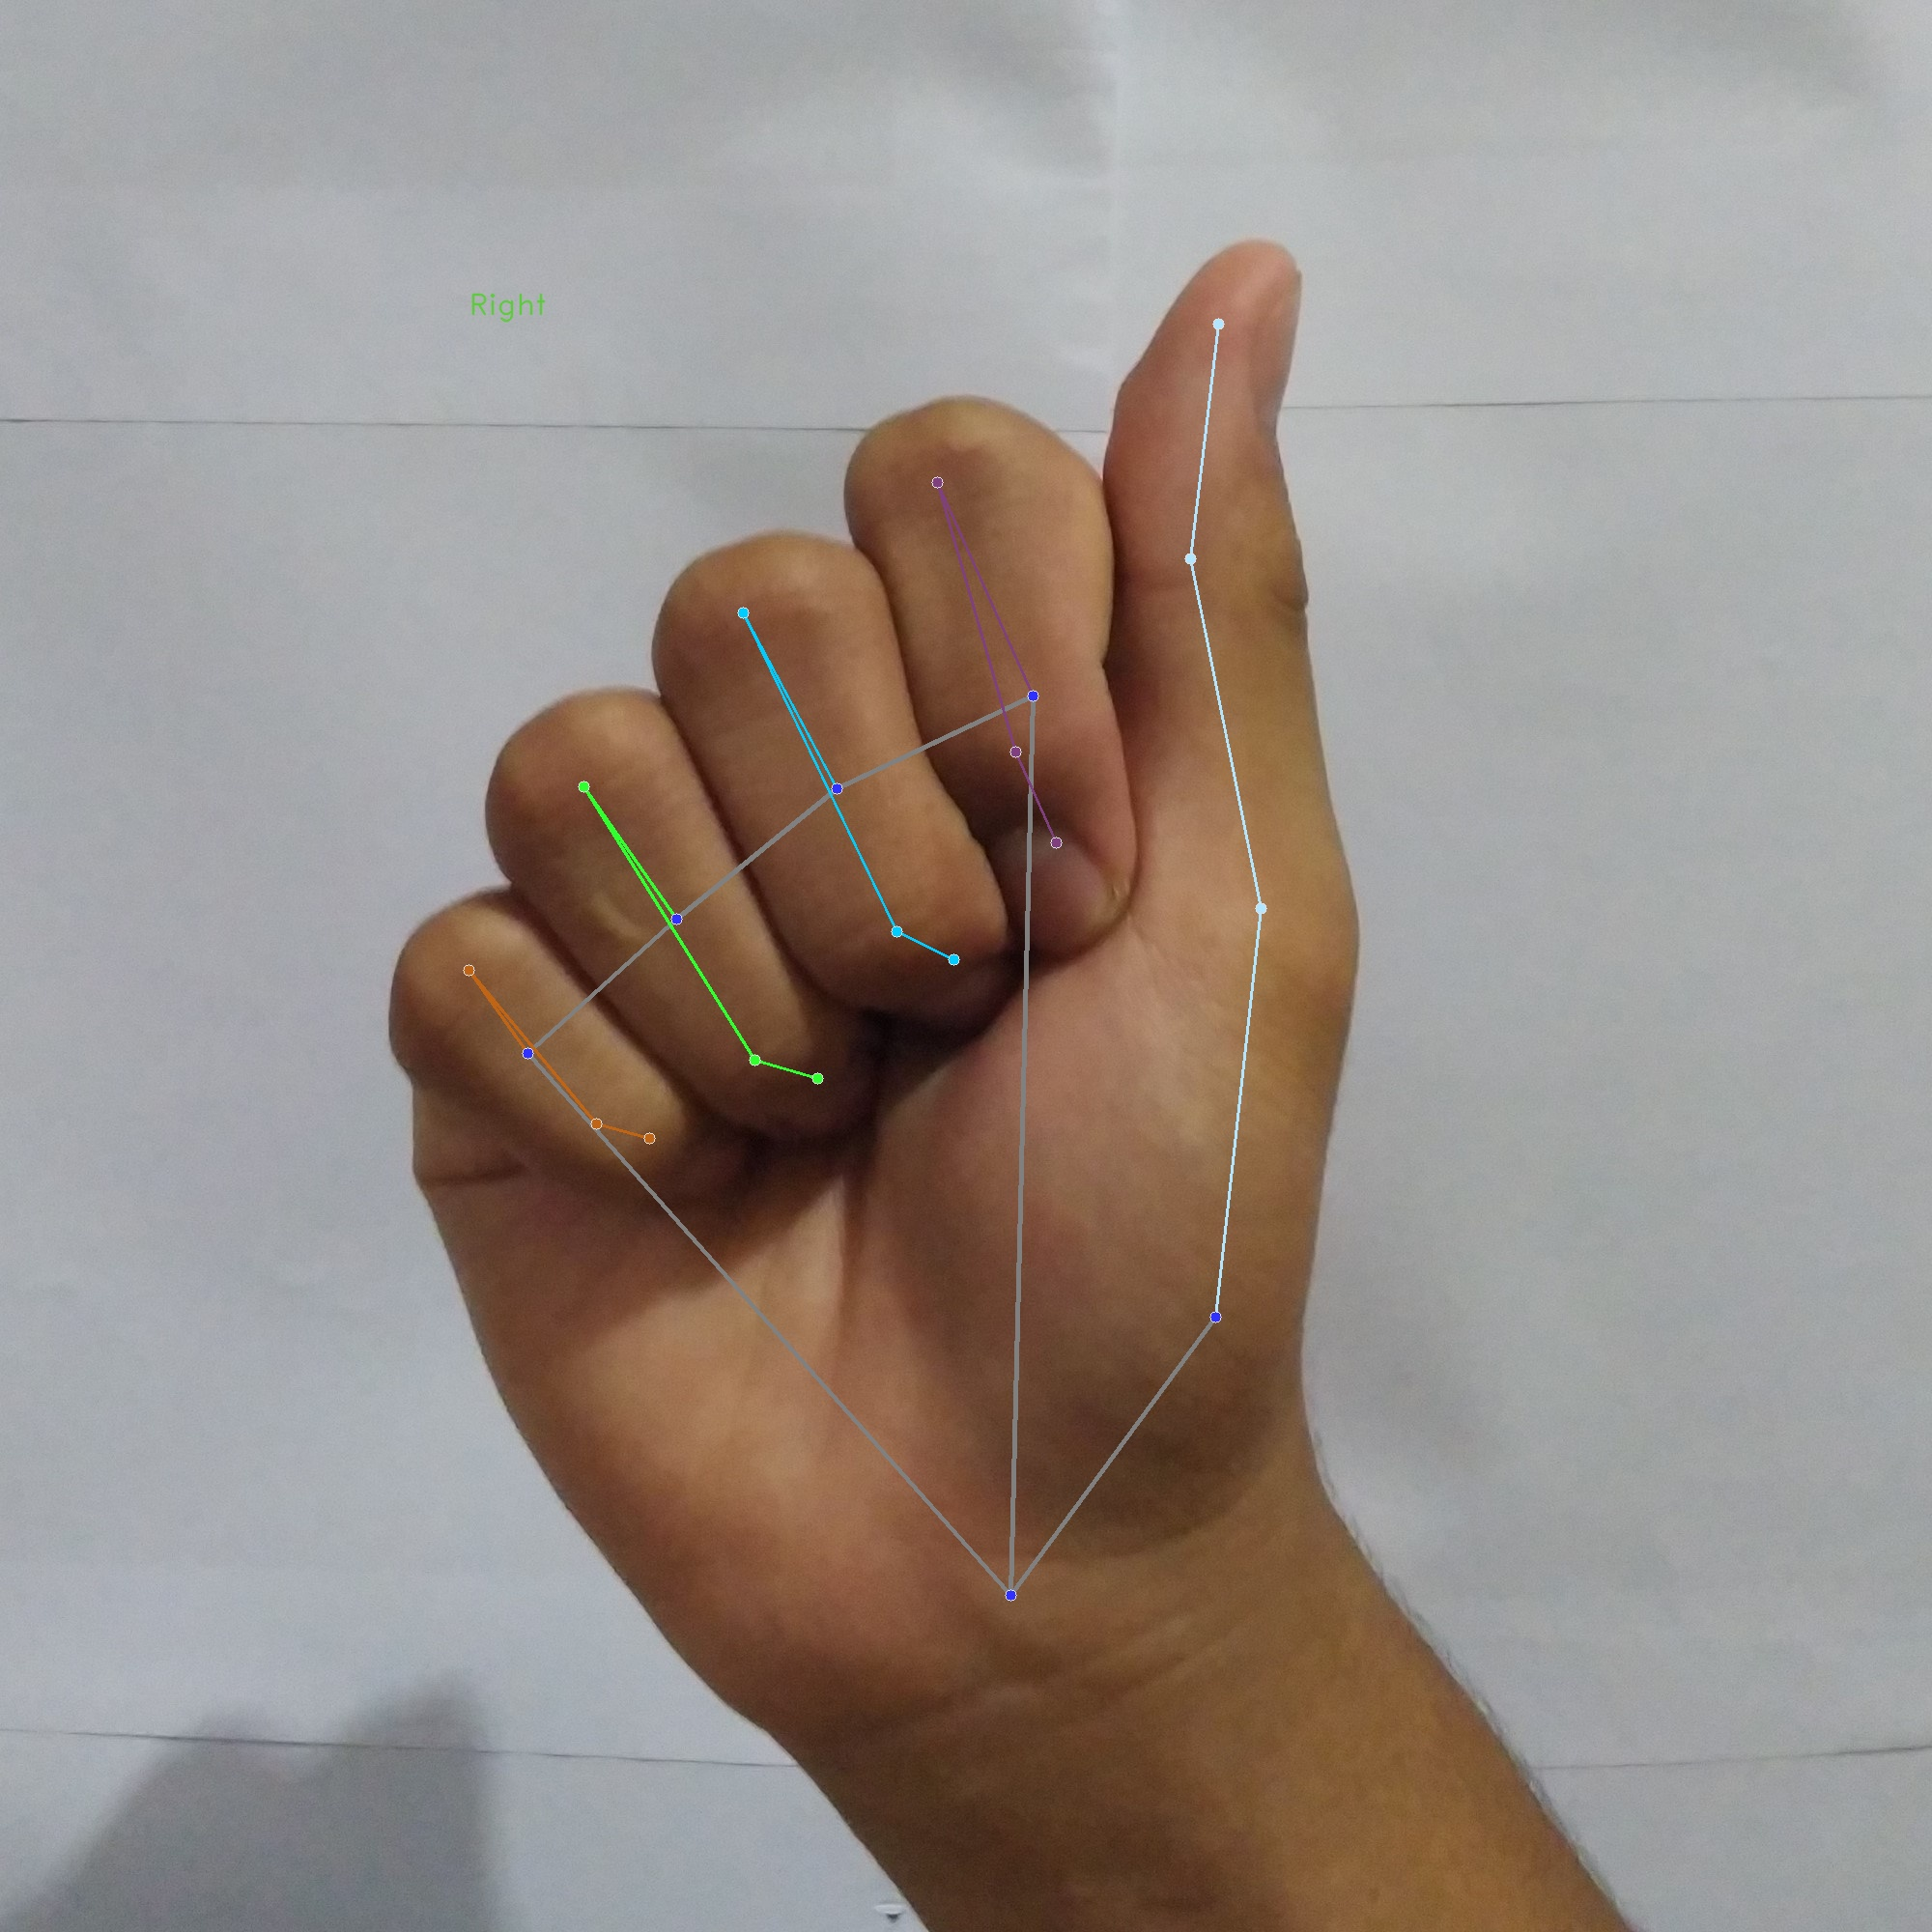

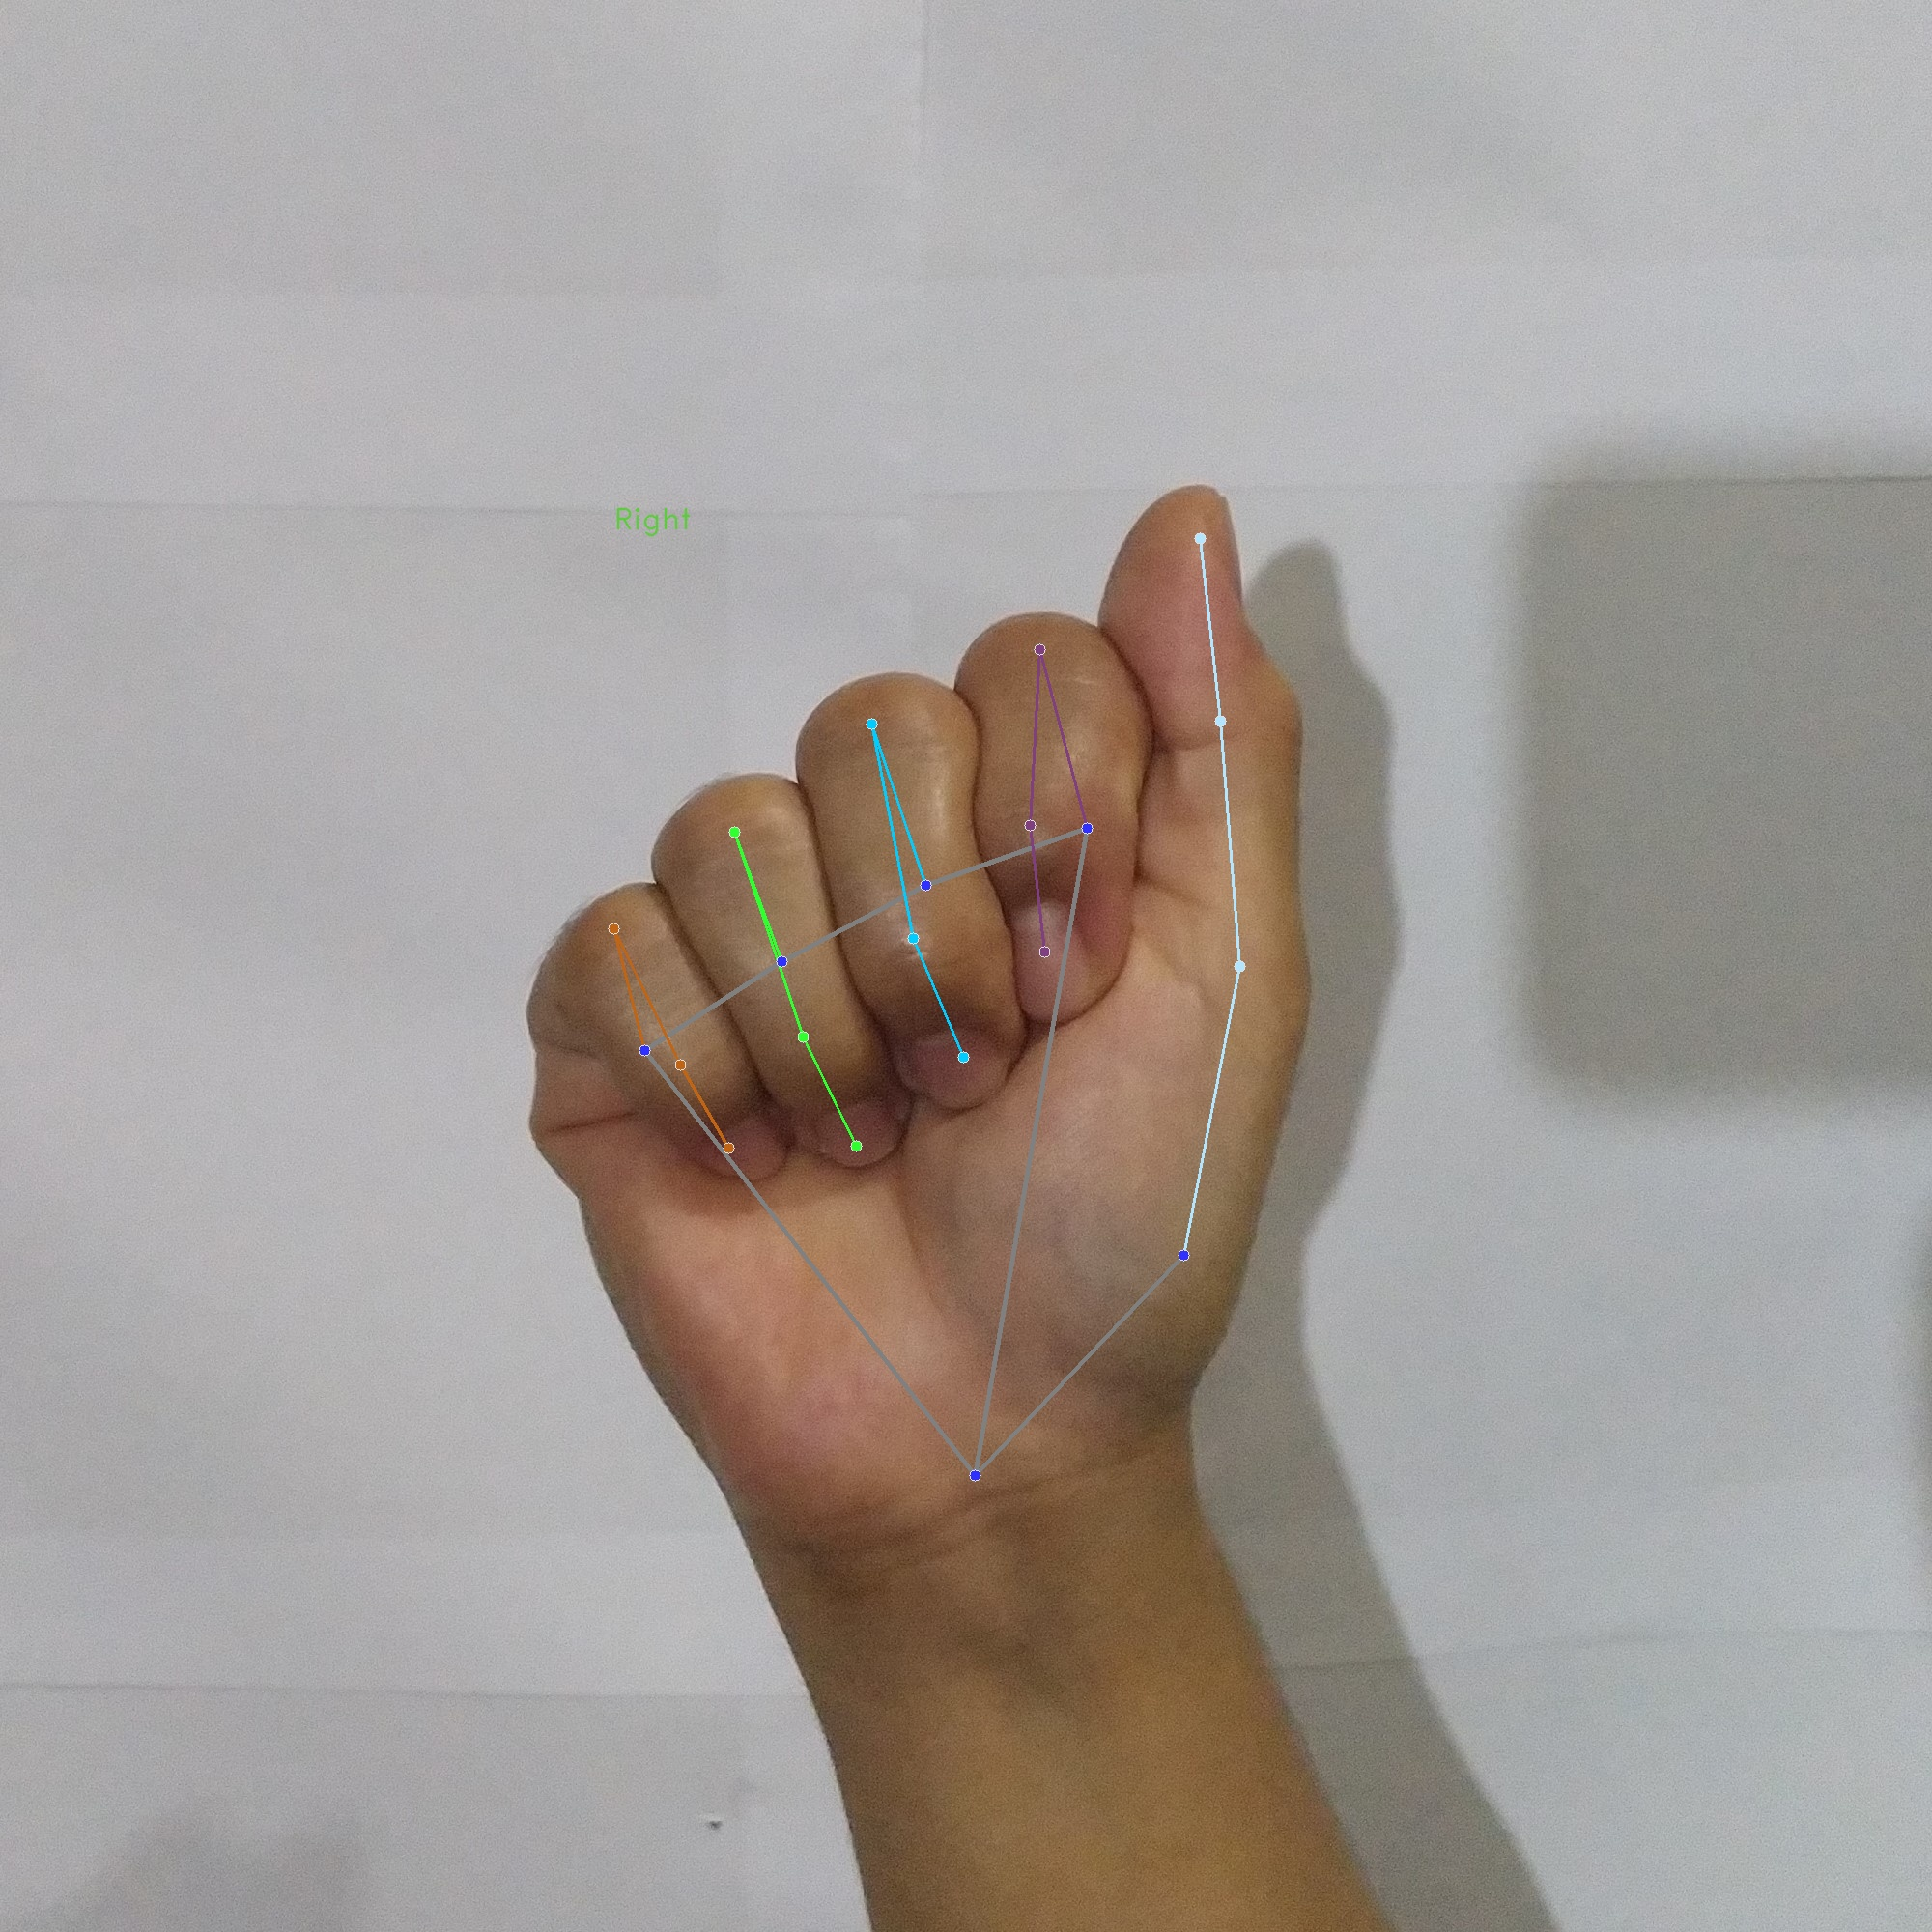

In [79]:
result1 = detect("sibi/A/A (1).jpg")
result2 = detect("sibi/A/A (10).jpg")

<Axes: >

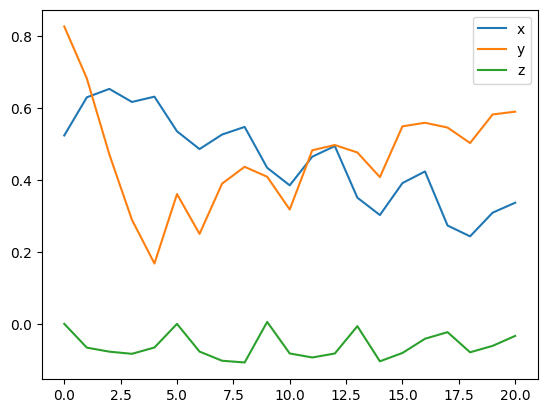

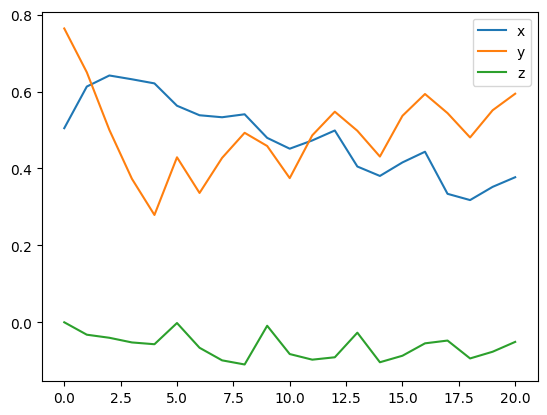

In [80]:
landmark2df(result1.hand_landmarks[0]).plot()
landmark2df(result2.hand_landmarks[0]).plot()

0
1
2


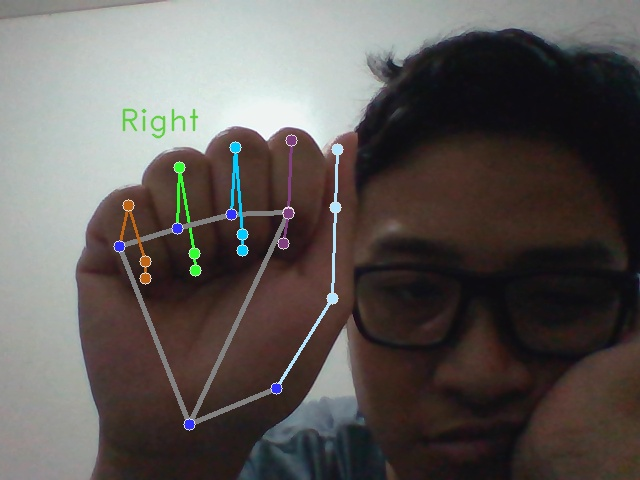

<Axes: >

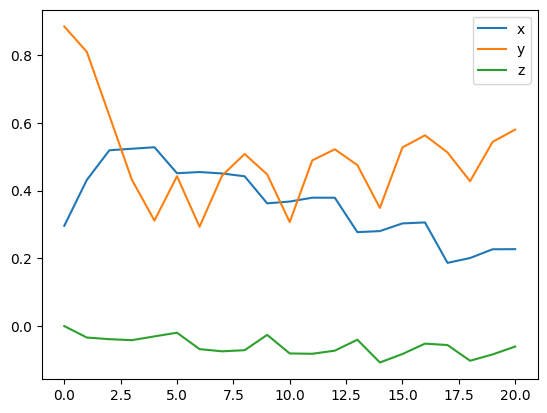

In [84]:
import time
cap = cv2.VideoCapture(0)

# Check if the camera opened successfully
if not cap.isOpened():
    print("Error: Could not open the camera.")
else:
    # Capture a single frame
    for i in range(3):
        print(i)
        time.sleep(1)
    ret, frame = cap.read()

    if not ret:
        print("Error: Couldn't capture a frame.")
    else:
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        result3 = detect(image_data=image)
cap.release()
landmark2df(result3.hand_landmarks[0]).plot()

<Axes: >

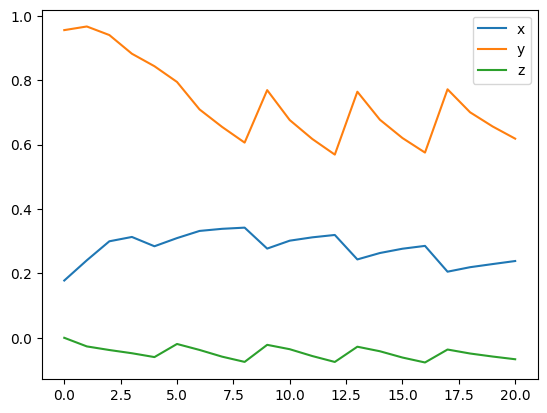

#### Data Generator


In [95]:
import string
import glob

image_dir = "sibi"
save_dir = "landmarks"

for char in string.ascii_uppercase:
    print(f"creating landmarks for {char}")
    images = glob.glob(f"{image_dir}/{char}/*.jpg")
    for image in images:
        print(f"processing {image}")
        res = detect(image_path=image, view=False)
        try:
            df = landmark2df(res.hand_landmarks[0])
            if not os.path.isdir(f"{save_dir}/{char}"):
                os.makedirs(f"{save_dir}/{char}")
            csv_name = os.path.basename(image).split(".")[0]
            df.to_csv(f"{save_dir}/{char}/{csv_name}.csv", index=False)
        except IndexError:
            print(f"skipping {image}")
            continue


creating landmarks for A
processing sibi/A\A (1).jpg
processing sibi/A\A (10).jpg
processing sibi/A\A (11).jpg
processing sibi/A\A (12).jpg
processing sibi/A\A (13).jpg
processing sibi/A\A (14).jpg
processing sibi/A\A (15).jpg
processing sibi/A\A (16).jpg
processing sibi/A\A (17).jpg
processing sibi/A\A (3).jpg
processing sibi/A\A (4).jpg
processing sibi/A\A (5).jpg
processing sibi/A\A_1.jpg
processing sibi/A\A_2.jpg
processing sibi/A\A_3.jpg
processing sibi/A\A_4.jpg
processing sibi/A\A_5.jpg
processing sibi/A\A_6.jpg
creating landmarks for B
processing sibi/B\B (1).jpg
processing sibi/B\B (10).jpg
processing sibi/B\B (11).jpg
processing sibi/B\B (12).jpg
processing sibi/B\B (13).jpg
processing sibi/B\B (14).jpg
processing sibi/B\B (15).jpg
processing sibi/B\B (3).jpg
processing sibi/B\B (4).jpg
processing sibi/B\B (5).jpg
processing sibi/B\B (8).jpg
processing sibi/B\B (9).jpg
processing sibi/B\B_1.jpg
processing sibi/B\B_2.jpg
processing sibi/B\B_3.jpg
processing sibi/B\B_4.jpg
proc

#### results

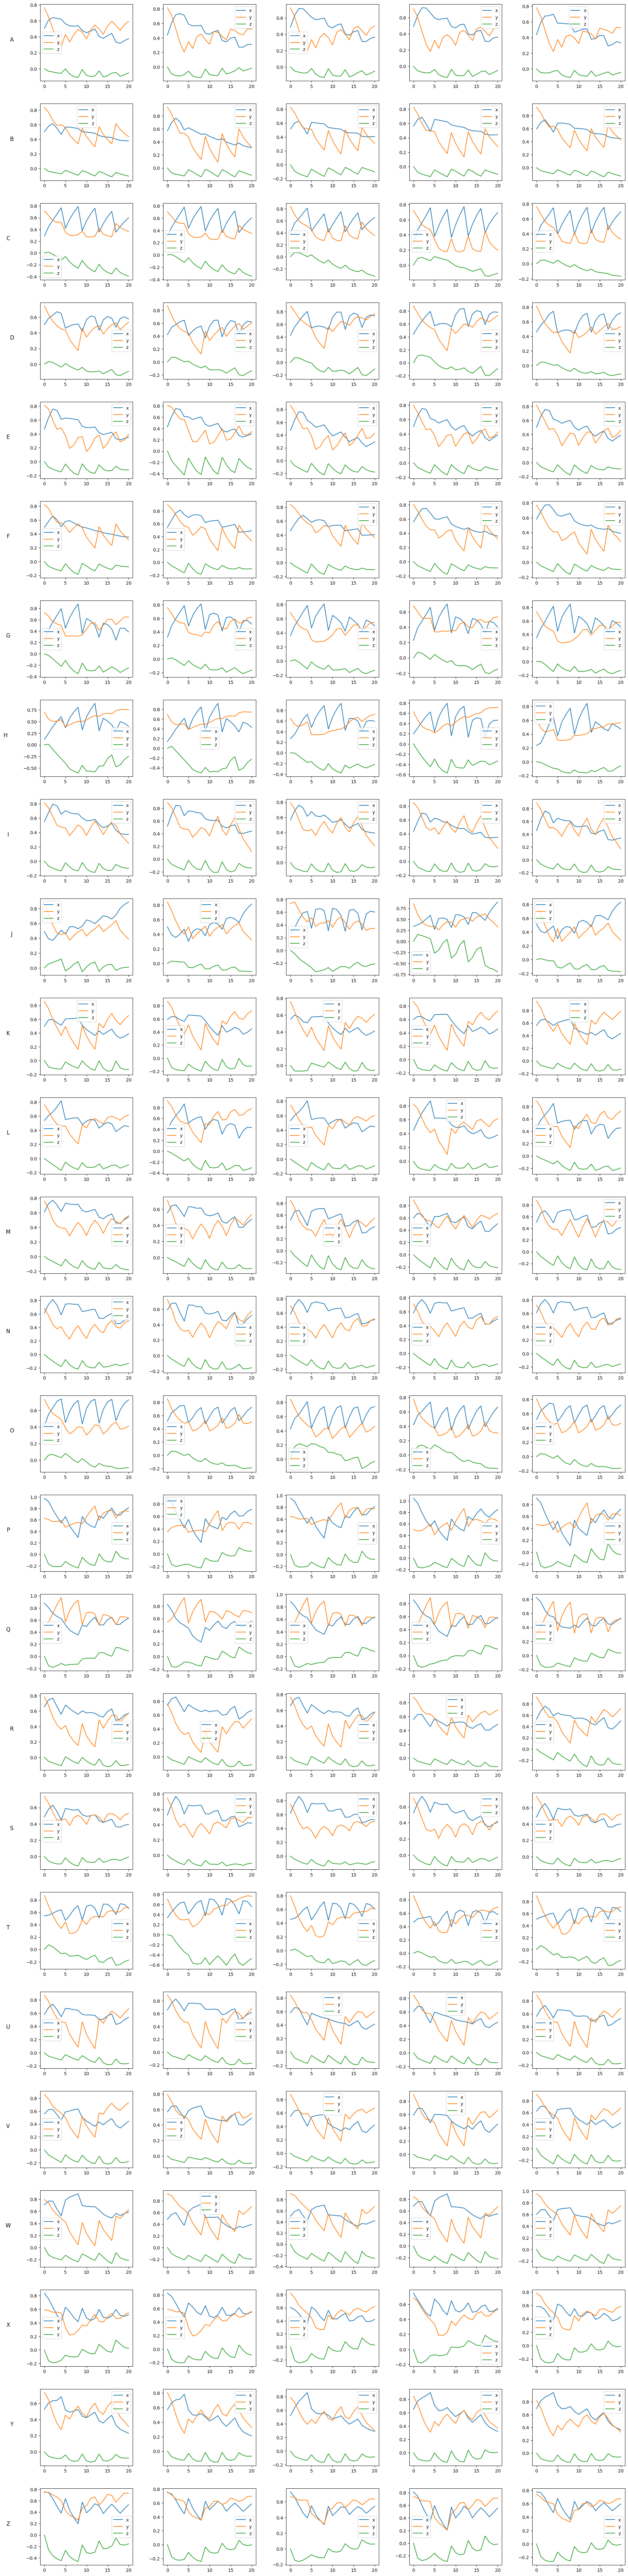

In [106]:
import random

# set the path to the landmarks directory
landmarks_dir = "landmarks"

# create a figure with 26 subplots, arranged in 5 columns and 26 rows
fig, axs = plt.subplots(26, 5, figsize=(20, 80))

# loop through all the subdirectories inside the landmarks directory
for i, subdir in enumerate(sorted(os.listdir(landmarks_dir))):
    subdir_path = os.path.join(landmarks_dir, subdir)
    
    # check if the subdirectory is a directory
    if os.path.isdir(subdir_path):
        # print(f"Plotting csv files from {subdir_path}")
        
        # use glob to list all the csv files inside the subdirectory
        csv_files = glob.glob(os.path.join(subdir_path, "*.csv"))
        
        # plot the first 5 csv files
        for j, csv_file in enumerate(random.sample(csv_files, 5)):
            df = pd.read_csv(csv_file)
            df.plot(ax=axs[i, j])
            # axs[i, j].plot(df["x"], df["y"])
        
        axs[i, 0].set_ylabel(subdir, rotation=0, size='large', labelpad=40)
# adjust the spacing between subplots
fig.tight_layout(pad=3.0)

# show the figure
plt.show()


In [3]:
import pandas as pd
df = pd.read_csv("landmarks/A/A (1).csv")

In [6]:
df.to_dict(orient='records')


[{'x': 0.5231891, 'y': 0.82590127, 'z': -6.2531024e-07},
 {'x': 0.6291219, 'y': 0.6818738, 'z': -0.06608615},
 {'x': 0.65254223, 'y': 0.47042274, 'z': -0.07732209},
 {'x': 0.6162557, 'y': 0.2892714, 'z': -0.083301336},
 {'x': 0.63090223, 'y': 0.16752817, 'z': -0.06579713},
 {'x': 0.5347509, 'y': 0.36039293, 'z': -0.00013532225},
 {'x': 0.48537186, 'y': 0.24985218, 'z': -0.07707882},
 {'x': 0.52575165, 'y': 0.38934657, 'z': -0.10254472},
 {'x': 0.54696, 'y': 0.4361297, 'z': -0.10734391},
 {'x': 0.43338978, 'y': 0.4084932, 'z': 0.005328934},
 {'x': 0.38467538, 'y': 0.31745774, 'z': -0.08230914},
 {'x': 0.4642687, 'y': 0.4821229, 'z': -0.09343871},
 {'x': 0.49373883, 'y': 0.4966315, 'z': -0.08246234},
 {'x': 0.35042003, 'y': 0.47597116, 'z': -0.0065518324},
 {'x': 0.3021638, 'y': 0.40748554, 'z': -0.10408207},
 {'x': 0.39095137, 'y': 0.5485134, 'z': -0.08090261},
 {'x': 0.4232098, 'y': 0.55846965, 'z': -0.041452322},
 {'x': 0.27310973, 'y': 0.54515064, 'z': -0.023082556},
 {'x': 0.2429834